# LeNet

Lenet is most earlies convolutional neural network to predict hand writing dataset (MNIST). In this notebook I will reproduce the LeNet and useing different training set to play round with the LeNet

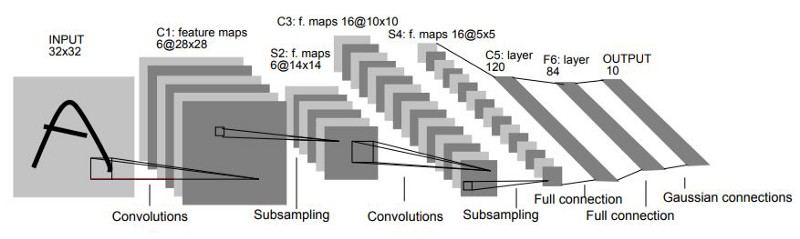

The structure of LeNet is: 
- Input: (1,28,28) (gray scale only have one channel, Color image have RGB three channel)
- Convolution Layer C1 (kernal size=(5,5),padding =2, feature_in =1 feature_out = 6)
- Average Pool Layer S2 (kernal size= (2,2),stride =2)
- Convolution Layer C3 (kernal size=(5,5), feature_in =6 feature_out = 10)
- Average Pool Layer S4 (kernal size= (2,2),stride =2)
- Flatten
- Linear(n,120)
- Linear(120,84)
- Linear(84,10)  10 class of output



In [1]:
# 
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.C1=nn.Conv2d(in_channels=1,out_channels=6,kernel_size=(5,5),padding=2)
        self.S2=nn.AvgPool2d(kernel_size=(2,2),stride=2)
        self.C3=nn.Conv2d(in_channels=6,out_channels=16,kernel_size=(5,5))
        self.S4=nn.AvgPool2d(kernel_size=(2,2),stride=2)
        self.linear1=nn.Linear(400,120)
        self.linear2=nn.Linear(120,84)
        self.linear3=nn.Linear(84,10)

        # flatten Layer
        self.flatten=nn.Flatten()
        
    def forward(self,x):
        x=self.C1(x)
        x=nn.Tanh()(x)
        x=self.S2(x)
        x=self.C3(x)
        x=nn.Tanh()(x)
        x=self.S4(x)
        # Flatten
        x=self.flatten(x)
        # Linear Layers with sigmoid activation function
        x=self.linear1(x)
        x=nn.Tanh()(x)
        x=self.linear2(x)
        x=nn.Tanh()(x)
        x=self.linear3(x)
        return x

# MNIST dataset

In [3]:
# transform data into tensor
transform=transforms.Compose([torchvision.transforms.ToTensor()])

In [4]:
# Get the MNIST train dataset and test dataset
train_dataset=datasets.MNIST('./data', train=True, download=True,transform=transform)
train_dl = DataLoader(train_dataset,batch_size=128, shuffle=True)
test_dataset=datasets.MNIST('./data', train=False, download=True,transform=transform)
test_dl = DataLoader(test_dataset,batch_size=128, shuffle=True)
print("number of image in train: ",len(train_dataset))
print("number of image in test: ",len(test_dataset))

number of image in train:  60000
number of image in test:  10000


In [5]:
x,y=next(iter(train_dl))
print("x: ",x.shape) 
print("y: ",y.shape)

x:  torch.Size([128, 1, 28, 28])
y:  torch.Size([128])


In [6]:
def train_one_epoch(train_dl,model,optimizer):
    train_loss=0
    for X,y in train_dl:
        model.train()
        y_pred = model(X)
        # update model and parameter
        optimizer.zero_grad()
        loss = F.cross_entropy(y_pred,y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X.size(0)
    train_loss = train_loss / len(train_dl.dataset)
    return train_loss

def valid(test_dl,model):
    ys=[]
    y_preds=[]
    for X,y in test_dl:
        model.eval()
        y_pred=model(X)
        loss = F.cross_entropy(y_pred,y)
        
        y_preds.append(y_pred)
        ys.append(y)
        
    y_preds=torch.cat(y_preds)
    ys=torch.cat(ys)
    
    test_loss =F.cross_entropy(y_preds,ys)
    accuracy=sum(y_preds.argmax(dim=1)==ys)/len(ys)
    return test_loss.item(),accuracy.item()

def train_loop(model,optimizer,train_dl,test_dl,epoch):
    for i in range(epoch):
        train_loss=train_one_epoch(train_dl,model,optimizer)
        test_loss, test_acc= valid(test_dl,model)
        print(f"""train loss:{round(train_loss,3)}, test loss: {round(test_loss,3)}, test acc: {round(test_acc,3)}""")
    

In [7]:
# train the model
model = LeNet() #init the Lenet
optimizer= torch.optim.SGD(model.parameters(),lr=0.5) # set optimizer
train_loop(model,optimizer,train_dl,test_dl,10)

train loss:0.307, test loss: 0.131, test acc: 0.96
train loss:0.085, test loss: 0.061, test acc: 0.98
train loss:0.056, test loss: 0.051, test acc: 0.984
train loss:0.044, test loss: 0.043, test acc: 0.986
train loss:0.034, test loss: 0.049, test acc: 0.985
train loss:0.029, test loss: 0.039, test acc: 0.987
train loss:0.023, test loss: 0.039, test acc: 0.988
train loss:0.018, test loss: 0.038, test acc: 0.987
train loss:0.015, test loss: 0.04, test acc: 0.987
train loss:0.012, test loss: 0.034, test acc: 0.989


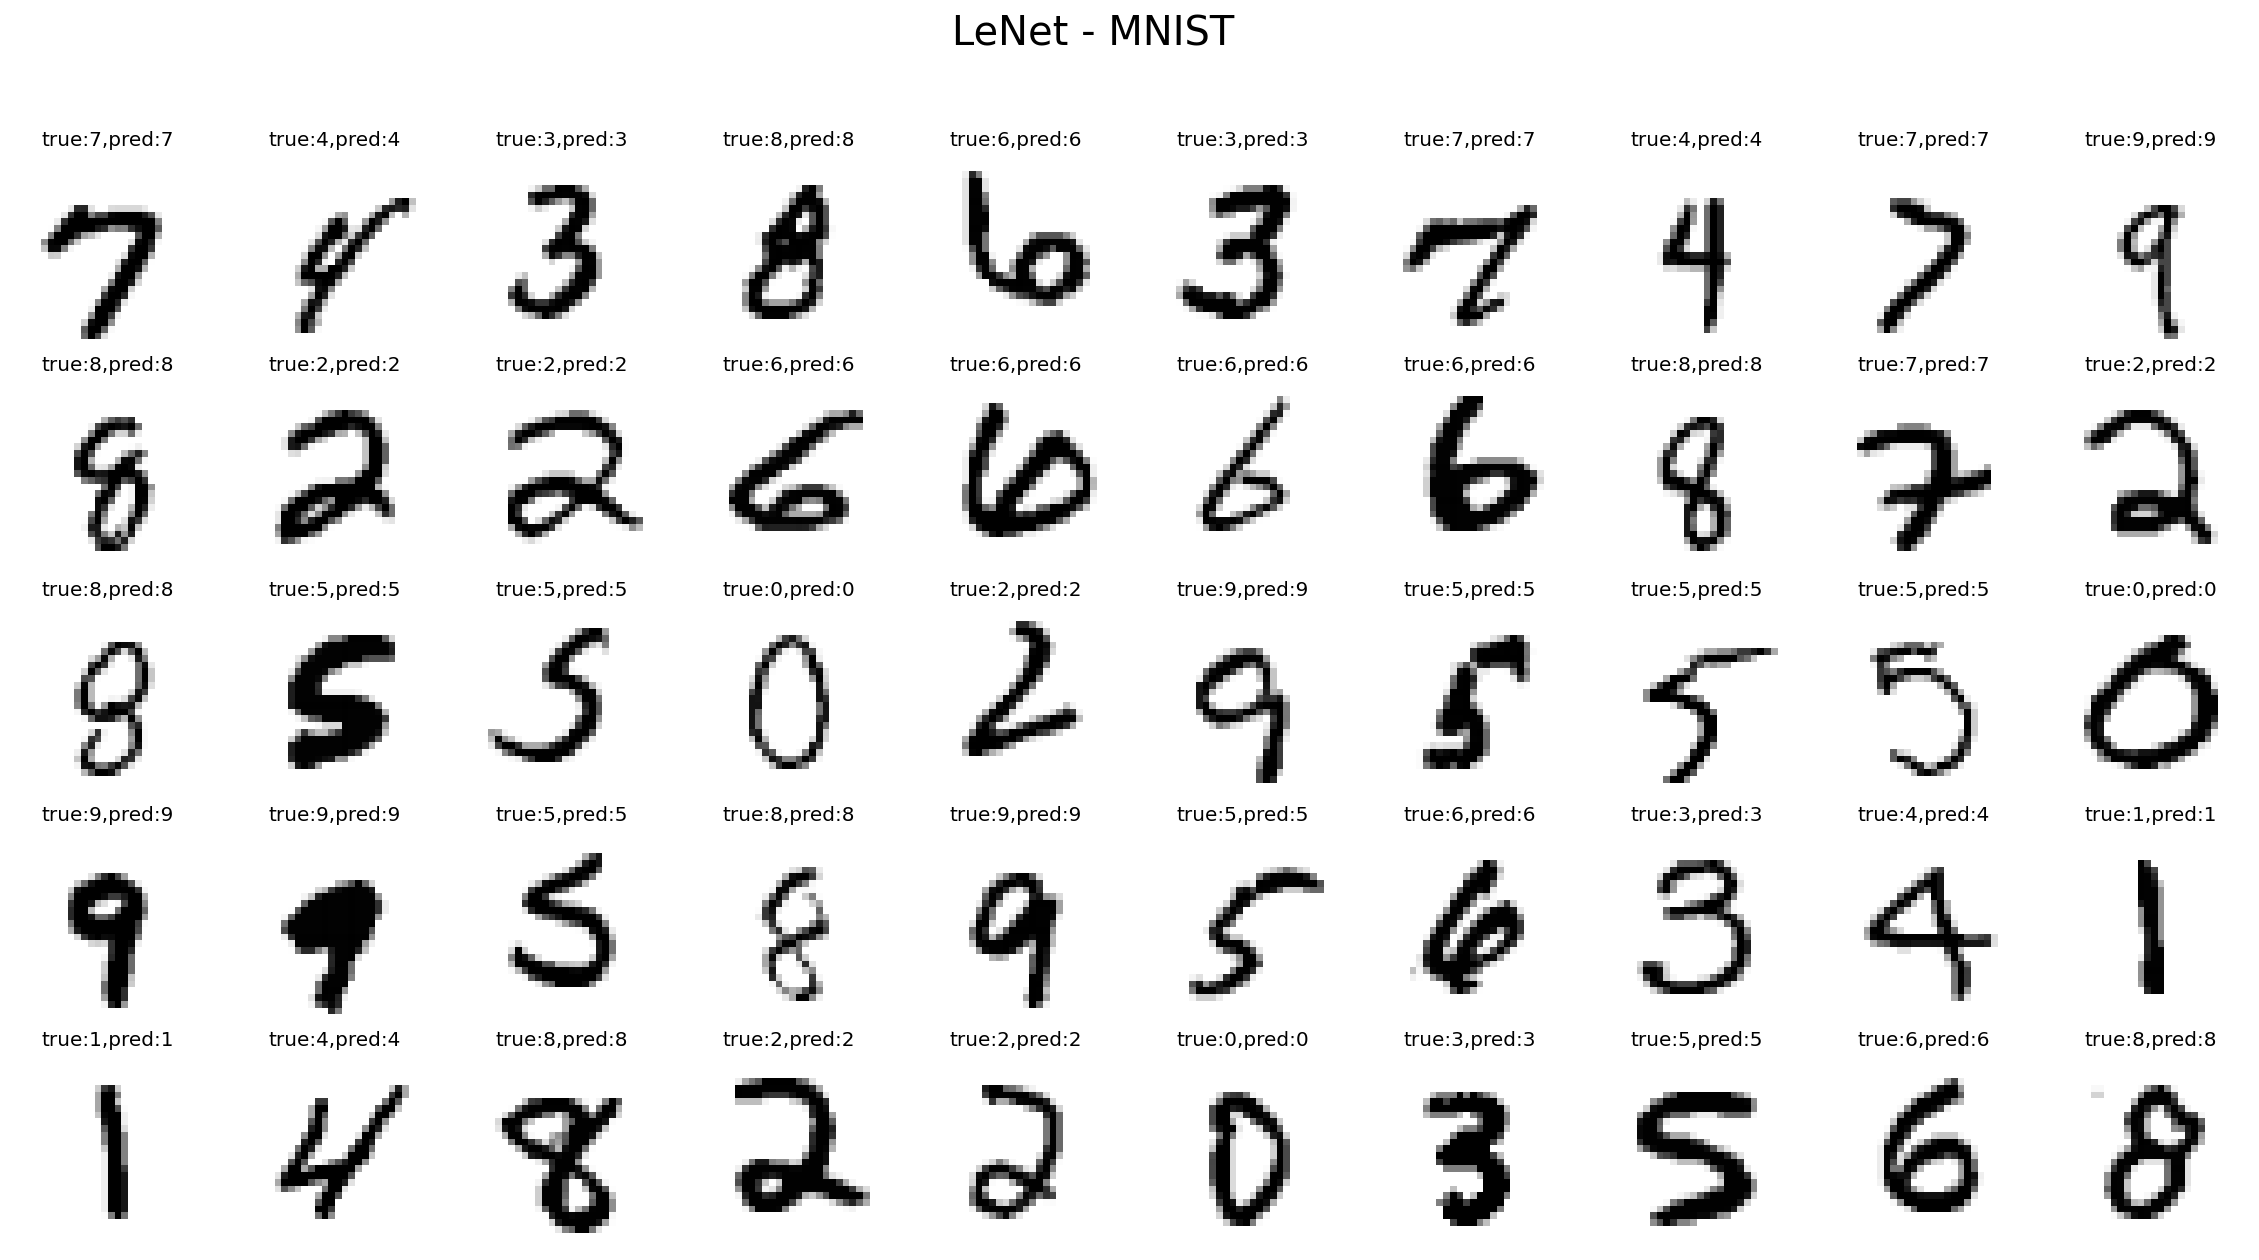

In [12]:
row = 10
col = 5
# get valid data set
valid_x,valid_y=next(iter(test_dl))[:50]
fig = plt.figure(figsize=(20,10))
pred_label=model(valid_x).argmax(dim=1)
true_label=valid_y
for i in range(1, row * col + 1):
    plt.subplot(col, row, i)
    plt.axis('off')
    plt.imshow(valid_x[i].squeeze(0), cmap='gray_r')
    title = f'true:{true_label[i]},pred:{pred_label[i]}'
    plt.title(title, fontsize=10)
fig.suptitle('LeNet - MNIST',fontsize=20)
plt.show()


# FashionMNIST dataset

Since the MNIST dataset is the most classical dataset. Let's try to implement LeNet with another dataset.

In [13]:
# Get the Fashion MNIST train dataset and test dataset
train_dataset=datasets.FashionMNIST('./data', train=True, download=True,transform=transform)
train_dl = DataLoader(train_dataset,batch_size=128, shuffle=True)
test_dataset=datasets.FashionMNIST('./data', train=False, download=True,transform=transform)
test_dl = DataLoader(test_dataset,batch_size=128, shuffle=True)

In [14]:
x,y = next(iter(train_dl))

In [15]:
model = LeNet() #init the Lenet
optimizer= torch.optim.SGD(model.parameters(),lr=0.5) # set optimizer
train_loop(model,optimizer,train_dl,test_dl,10)

train loss:0.638, test loss: 0.49, test acc: 0.82
train loss:0.401, test loss: 0.375, test acc: 0.863
train loss:0.353, test loss: 0.371, test acc: 0.86
train loss:0.326, test loss: 0.365, test acc: 0.867
train loss:0.303, test loss: 0.328, test acc: 0.878
train loss:0.286, test loss: 0.331, test acc: 0.877
train loss:0.27, test loss: 0.336, test acc: 0.88
train loss:0.259, test loss: 0.339, test acc: 0.879
train loss:0.249, test loss: 0.338, test acc: 0.873
train loss:0.237, test loss: 0.307, test acc: 0.885


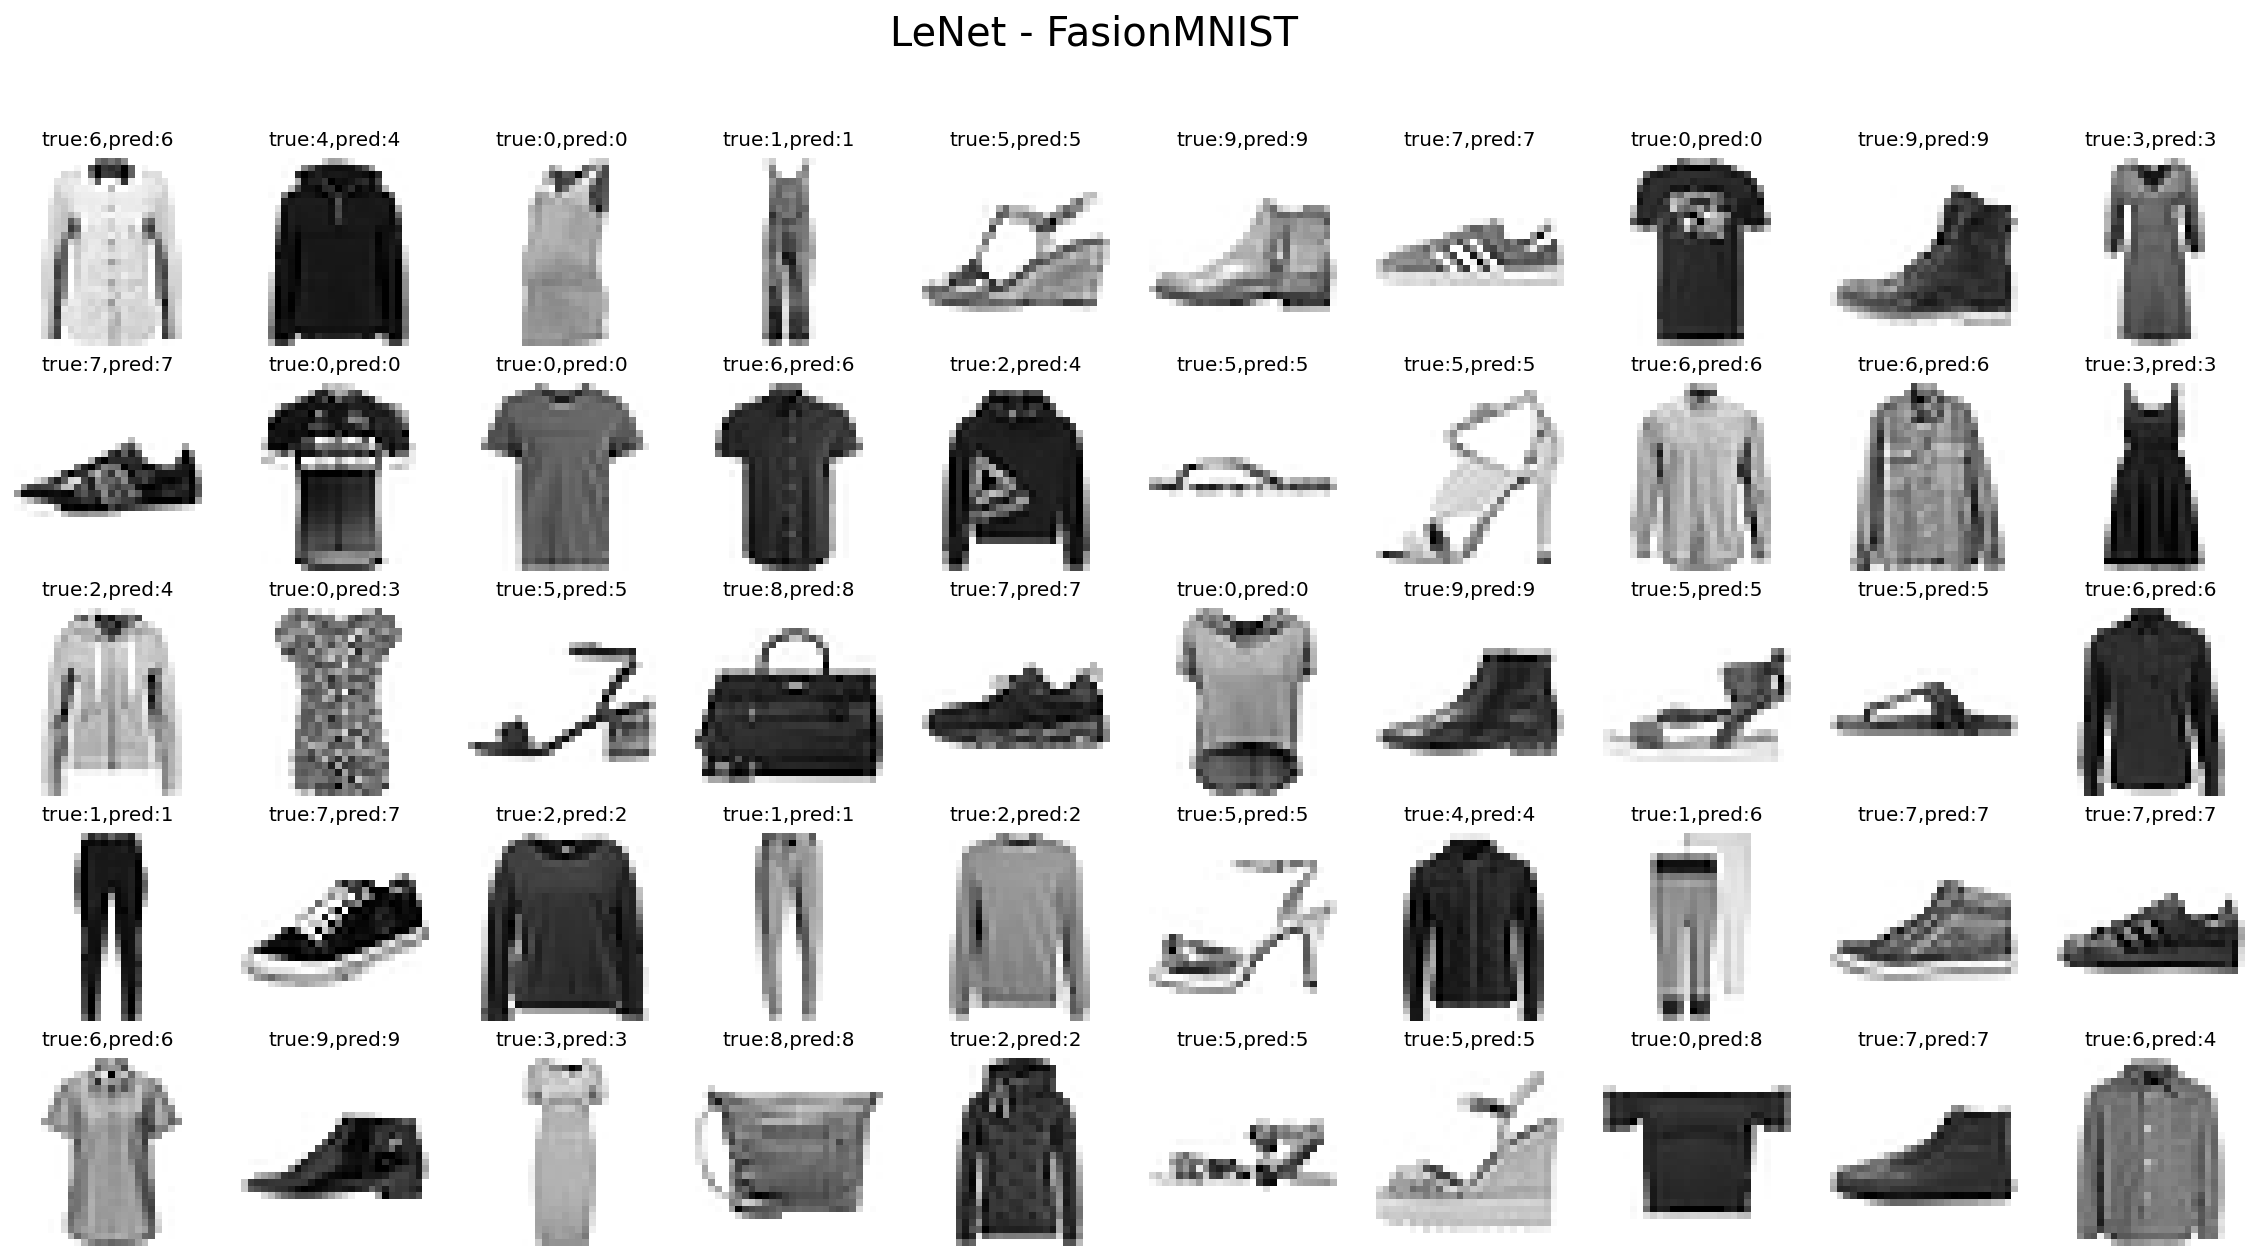

In [16]:
row = 10
col = 5
valid_x,valid_y=next(iter(test_dl))[:50]
fig = plt.figure(figsize=(20,10))
pred_label=model(valid_x).argmax(dim=1)
true_label=valid_y
for i in range(1, row * col + 1):
    plt.subplot(col, row, i)
    plt.axis('off')
    plt.imshow(valid_x[i].squeeze(0), cmap='gray_r')
    title = f'true:{true_label[i]},pred:{pred_label[i]}'
    plt.title(title, fontsize=10)
fig.suptitle('LeNet - FasionMNIST',fontsize=20)
plt.show()